**Содержание темы**

1.  [Теория](https://colab.research.google.com/drive/1Qfic-ckzSmXUZ5pyQ7YDzE_gLq9hIA_T?usp=sharing)
2.  Практический ноутбук 1
3. [Практический ноутбук 2](https://colab.research.google.com/drive/16lyctI5oJzVhVC3nQmIIs0tzFRPFPAk_?usp=sharing)

## Обучение алгоритма REINFORCE

Алгоритм учится играть в игру Pong.

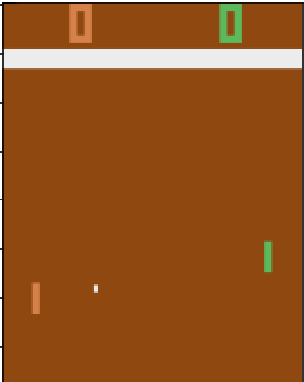

**Правила игры Pong**

Есть два игрока: зеленый (управляется агентом) и оранжевый (управляется средой). На каждом моменте игры игроки могут двигаться вверх, вниз или стоять на месте.

Есть небольшой «мяч», который двигается между игроками. Мяч отбивается при контакте с одним из игроков. Цель игры — забить гол противнику и не дать ему забить себе. За каждый гол, который забивает агент, назначается положительная награда +1. За каждый гол, который противник забивает агенту, назначается отрицательная награда -1. 

Текущий счет можно узнать, посмотрев на цифры, которые находятся над игровым полем. Игра заканчивается, когда один из игроков забивает 21 гол.

**Важно!**  О фреймворке Gym.

Gym — это встроенная библиотека в Colab, то есть ее не нужно загружать через `!pip install`, чтобы импортировать функции. Однако с последнего обновления фреймворка (май 2021) нужно через команду отдельно скачать некоторые файлы, чтобы запускать ее среды. Как вариант — откатить версию библиотеки через файлы.

Ниже представленный код скачивает, распаковывает и импортирует нужные ROM-файлы для правильной работы среды. Этот код нужно обязательно запускать при каждом запуске Colab.

In [ ]:
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l7/pretrained.zip', None, quiet = True)
!unzip -q pretrained.zip

In [ ]:
!pip install "gym[atari, accept-rom-license]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 KB 48.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 96.6 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.0-py3-none-any.whl size=446686 sha256=6e651bc4a7173795f2783c9ba0bfb7361e413d388a4576100cf81d946815dda9
  Stored in directory: /root/.cache/pip/wheels/7d/17/c9/c31922a6aaf4ec7ec90eeee5dbc40ffbaafeda64b30a208b72
Successfully built AutoROM.accept-rom-license


In [ ]:
# установка пакета для рендера видео
!pip install pyvirtualdisplay > /dev/null 2>&1

# установка обертки для пакета, который позволит воспроизводить видео в ячейке колаба
!pip install xvfbwrapper   

# обновляем все пакеты до новейшей версии, чтобы все пакеты "подружились"
!apt-get update 

# установка удаленного сервера, благодаря которому видео будет воспроизводиться в ячейке колаба
!sudo apt-get install xvfb 

# пакет для вывода процессов, происходящих на сервере
!apt-get install xdpyinfo 

Импортируем все нужные модули и библиотеки, подключаемся к диску:

In [ ]:
# Библиотека Gym (встроенная в Colab)
import gym     
from gym import logger as gymlogger
from gym.wrappers import RecordVideo 
# для правильного отображения ошибок
gymlogger.set_level(40) 

# расширение для использования Unix обозначений при задании пути к файлу
import glob 

# для работы с папками
import shutil
import os

# библиотека для работы с потоковыми данными
import io 

# расширение для преобразования в формат base64
# (универсальный формат хранения сырых изображений в виде набора электрических сигналов)
import base64 

# библиотека для кодирования в код HTML
from IPython.display import HTML 

# библиотека для расчета времени обучения
import time 

# для работы с "сырым" форматом (набор сигналов, а не пиксели)
from IPython import display as ipythondisplay 

# NumPy
import numpy as np 

# Функция для создания модели и загрузки модели
from tensorflow.keras.models import Model, load_model 

# Все слои Keras
from tensorflow.keras.layers import * 

# Оптимизатор RMSprop
from tensorflow.keras.optimizers import RMSprop 

# Tensorflow
import tensorflow as tf     

# pyplot для визуализации данных
import matplotlib.pyplot as plt

# Модуль pickle для сохранения и загрузки данных
import pickle  

# Библиотека cv2 (используется для воспроизведения видео)
import cv2           

# Функция для управления вывода в Colab-ячейках
from google.colab import output         
from pyvirtualdisplay import Display 
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
def show_video():
  '''
  Функция, позволяющая записывать видео того,
  что происходит в окружении и отображать это в колаб

  '''
  # для поиска JPG файлов используем модуль glob.
  mp4list = glob.glob('video/*.mp4')

  if len(mp4list) > 0: # если лист не нулевой
    mp4 = mp4list[0] # получаем данные
    video = io.open(mp4, 'r+b').read() # открываем и читаем данные
    encoded = base64.b64encode(video)
    # формируем область вывода видео
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: # если лист пуст выводим тех.сообщение
    print("Could not find video")
    

def wrap_env(env):
  if (os.path.isdir('/content/video')):
      shutil.rmtree('/content/video')
  return RecordVideo(env, './video', new_step_api=True, )

In [ ]:
env = gym.make('ALE/Pong-v5')   
env = wrap_env(env)

# Запускаем среду (это действие возвращает начальное состояние)
new_frame = env.reset()        

# Взглянем на размерность состояния
print(f"Размерность состояния: {new_frame.shape}")  

Размерность состояния: (210, 160, 3)


In [ ]:
# Взглянем на все возможные действия и узнаем, что они делают 
env.unwrapped.get_action_meanings() 

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

###Возможные действия

0. `Noop` — ничего не делать.
1. `Fire` — запустить мяч.
2. `Right` — двигать вправо.
3. `Left` — двигать влево.
4. `Rightfire` — двигать вправо и запускать мяч.
5. `Leftfire` — двигать влево и запускать мяч.

Поскольку конкретная игра создана под платформу Atari, в ней шесть разных действий, но некоторые из них фактически делают одно и то же, например `Right` и `Rightfire`.

Поэтому есть смысл не давать агенту использовать все действия, а создать список из действий, которые можно использовать.

In [ ]:
# Создаем массив возможных действий. Агент может стоять на месте, двигаться влево или вправо
action_space = [0, 2, 3] 

# Записываем в переменную количество уникальных возможных действий — также известно как размерность пространства действий
num_actions = len(action_space) 

Используем `pyplot`, чтобы посмотреть на различные кадры, которые мы получаем из среды. Подадим 20 рандомных действий в среду и взглянем на каждый кадр, который получается после каждого действия. Это поможет нам понять, как выглядит игровой процесс.

###Логика взаимодействий с Gym-играми

Мы подаем действие на вход в виде скалярного значения. В примере ниже это действие выбирается рандомно из всех возможных действий, которые определяются выше.

На выходе мы получаем: 


  1. `new_frame` — новый кадр.
  2. `reward` — награда. Автоматически назначается средой. В данном случае награда +1 означает забивание гола врагу, награда -1 означает, что агенту забили гол.
  3. `done` — булевое значение, говорит, если игра закончилась.
  4. `misc` — прочая информация об игровой среде (редко используется).

In [ ]:
env = wrap_env(gym.make('ALE/Pong-v5'))
env.reset()     

# Запускаем цикл 20 раз
for i in range(20): 

  # Подаем рандомное действие на вход. На выходе получаем новую информацию о текущем состоянии игры
  new_frame, reward, done, misc, _ = env.step(np.random.choice(action_space)) 
  
env.close()
show_video()

## Предобработка состояний среды

Посмотрев на игровой кадр выше, можно заметить, что изображение содержит много лишней информации — цвет, баллы, границы, и т. д. Крайне желательно предобработать данные, чтобы убрать все это.

Также отсутствует критически важная информация — направление и скорость движения мяча, а также обоих игроков. Мы не можем узнать эту информацию из одного неподвижного кадра. Чтобы добавить ее, склеим два последовательных кадра вместе через конкатенацию.

*Примечание: возможно, что на картинке выше не видно мяча или второго игрока. Это потому, что они появляются не на первом кадре игры, а где-то на десятом.*

Создадим функцию для предобработки кадра — превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.

In [ ]:
def preprocess_frame(frame):      

  ''' Функция предобработки кадра. 
      Превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.

      Аргументы: 
      frame - кадр
      
  '''

  # Меняем тип данных на float32
  frame = frame.astype(np.float32) 
  
  # Отсекаем ненужные части кадра, которые не принадлежат игровому полю
  frame = frame[35:195]           

  # Сжимаем изображение (берем каждый второй пиксель) 
  frame = frame[::2, ::2, 0]       
  
  # Удаляем фон (меняем на черный цвет — значение пикселя = 0)
  frame[frame == 144] = 0    

  # Удаляем фон (меняем на черный цвет — значение пикселя = 0)      
  frame[frame == 109] = 0    

  # Всё, что не принадлежит фону, меняем на белый цвет (значение пикселя = 1)  
  frame[frame != 0] = 1            
  
  return frame.reshape(80, 80, 1)  # Меняем форму итогового кадра на (80, 80, 1)

Создадим функцию для склеивания двух кадров. Этот процесс даст нам текущее состояние, которое будет подаваться на вход нейронной сети.


In [ ]:
def stack_frames(new_frame, 
                 old_frame):                  
                 
  ''' Функция склеивания кадров 
      Превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.

      Аргументы: 
      new_frame — новый кадр
      old_frame — старый кадр
      
  '''

  # Предобрабатываем новое изображение (используем выше объявленную функцию)
  new_frame = preprocess_frame(new_frame)  
  
  # Предобрабатываем старое изображение (используем выше объявленную функцию)                
  old_frame = preprocess_frame(old_frame)                  
  
  return np.concatenate([new_frame, old_frame], axis = -1) # Склеиваем изображения по 3-й (канальной) оси, и возвращаем.

## Создание нейронной сети

Сеть принимает на вход состояние с размерностью `(80, 80, 2)`. На выходе будет слой с тремя нейронами, т. к. у нас три возможных действия, в которых будет содержаться вероятность принятия каждого действия.

In [ ]:
def create_model():                     

  ''' Функция создания модели '''

  input = Input((80, 80, 2))             # Задаем входную размерность — (80, 80, 2)
  
  x = Flatten()(input)                   # Применяем выравнивающий слой
  x = Dense(1024, activation = 'elu')(x) # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  x = Dense(512, activation = 'elu')(x)  # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  
  output = Dense(num_actions, 
                 activation = 'softmax')(x) # Выходной слой, где считается вероятность совершения нужного действия

  # Создаем модель
  model = Model(input, output)   

  # Компилируем модель — используем оптимизатор RMSprop с низким шагом обучения
  model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy') 

  return model   

## Создание функций

### Выбор действия

Нейронная сеть выдает вероятности принятия каждого действия. Ниже созданная функция использует эти вероятности для выбора конкретного действия.

In [ ]:
def choose_action(state):     

  ''' Функция выбора действия 

      Аргументы: 
      state — состояние

  '''

  # Делаем предсказание
  probs = model.predict(state.reshape(1, 80, 80, 2), verbose=False)   
  
  # Выбираем индекс действия рандомно, используя предсказанные вероятности модели
  action_index = np.random.choice(num_actions, p = probs.flatten()) 
  
  # Возвращаем индекс рандомно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс)
  return action_index     

### Предобработка наград

В теоретической части урока упоминалось, что нам необходимо предобрабатывать награды для корректного обучения алгоритма. В данном случае у нас скудные награды, но мы должны предобработать их, чтобы какая-то награда назначалась за каждое действие.

In [ ]:
def preprocess_rewards(rewards_list):

  ''' Функция предобработки наград. 

      Аргументы: 
      rewards_list - состояние

  '''
  # Инициализируем массив обработанных наград нулями
  discounted_rewards = np.zeros_like(rewards_list)  

  # running_add содержит предобработанную награду, которая назначается за действие — инициализируется нулем    
  running_add = 0                                       
  
  # Итерируем через массив наград в обратном порядке
  for i in reversed(range(len(discounted_rewards))):    
    
    # Если на заданный момент есть ненулевая награда, которая была назначена средой 
    if rewards_list[i] != 0:                            
      # переменная running_add обнуляется
      running_add = 0                                   
    
    # Задаем награду за текущее действие (псевдо-уравнение Беллмана)
    running_add = gamma * running_add + rewards_list[i] 

    # Записываем награду в массив обработанных наград
    discounted_rewards[i] = running_add                 
  
  # Возвращаем массив обработанных наград
  return discounted_rewards                  

### Визуализация качества работы агента

Ниже созданная функция рисует график, отображающий суммарную награду и длительность каждого эпизода (измеряется количеством состояний и действий за эпизод). 

Из-за рандомных факторов в среде и в самом алгоритме, награда и длина эпизода будут сильно варьироваться при обучении, что приведет к сложностям при нахождении какой-либо тенденции. 

Поэтому мы также будем считать скользящее среднее от награды и длины эпизода. Эти значения будут использоваться в качестве метрики, с помощью которых мы можем понять, с какой скоростью и насколько хорошо обучается алгоритм.

Для подсчета скользящего среднего используется функция свертки.

In [ ]:
def show_scores(scores, 
                episode_durations):

  ''' Функция отображения наград за эпизод. 

      Аргументы: 
      scores -  
      episode_durations - 

  '''    

  # Удаляем предыдущий вывод ячейки
  output.clear() 

  # Устанавливаем большой размер полотна
  fig, axes = plt.subplots(1, 2, figsize = (20, 8))    

  # Отрисовываем награды                        
  axes[0].plot(scores, linestyle = '--', label = 'Награда за эпизод')  

  # Считаем и отрисовываем скользящее среднее от награды        
  axes[0].plot(moving_average(scores), label = 'Скользящее среднее награды') 

  # Добавляем лейблы осей  
  axes[0].set_xlabel('Эпизод', fontsize = 12)                                  
  axes[0].set_ylabel('Награда', fontsize = 12)

  # Создаем легенду
  axes[0].legend()         
  
  # Отрисовываем длину эпизодов
  axes[1].plot(episode_durations, 'r', linestyle = '--', label = 'Длина эпизода (количество действий)')  
  
  # Считаем и отрисовываем скользящее среднее по длины эпизода
  axes[1].plot(moving_average(episode_durations), 'k', label = 'Длина эпизода (Скользящее среднее)')    
  
  # Добавляем лейблы осей
  axes[1].set_xlabel('Эпизод', fontsize = 12)                                                            
  axes[1].set_ylabel('Количество действий', fontsize = 12)
  
  # Создаем легенду
  axes[1].legend()         
  
  # Выводим график
  plt.show()

Также мы создадим функцию подсчета скользящего среднего всех значений. Это будет осуществляться через математическую свёртку, и мы будем считать скользящее среднее за 20 значений.

In [ ]:
def moving_average(data, 
                   width = 20): 

  ''' Функция подсчета скользящего среднего всех значений
      
      Аргументы:
      data — входной массив,
      width — длина, на которую считаем скользящее среднее
  '''

  # Длина свертки (минимум из заданной длины свертки и длины датасета)
  width = min(width, len(data))  

  # Вместо паддинга из нулей мы создадим паддинг для свертки из первого значения массива. Весь паддинг будет слева (в начале массива)    
  data = np.concatenate([np.repeat(data[0], width), data])  
   
  # Возвращаем результат свертки данных на фильтр из единиц — наше скользящее среднее
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  

### Обучение модели

Рассмотрим логику обучения модели:

1. Внутри игрового цикла модель принимает состояния на вход и предсказывает действия: сначала предсказывает вероятности действий, затем рандомным образом выбирает итоговое действие.

2. Для обновления весов модель принимает те же состояния на вход и предсказывает те же вероятности для принятия каждого действия. Если бы на этом заканчивался код, модель бы пыталась предсказывать все те же самые действия, которые были приняты в игре.

3. Вместо этого мы добавляем аргумент `sample_weight`, который позволяет считать значение ошибки так, чтобы некоторые примеры имели наибольшее влияние на подсчет значения ошибки, чем другие. Обычно это используют для борьбы с разбалансированным датасетом.

4. Значения, которые подаются в `sample_weight`, также могут быть отрицательными. В этом случае ошибка и ее градиент будут инвертированы в отрицательное, и при обучении модель будет стремиться НЕ предсказывать ответ в `y_train`. Это значит, что после обновления весов вероятность выбора действия в `y_train` будет ниже, а вероятности выбора всех остальных действий — выше.

5. В данном алгоритме в `sample_weight` подается массив всех наград, которые были получены в игровом эпизоде. Если действие привело к положительной награде в будущем (т. е. текущее значение предобработанной награды — положительное), то модель будет стремиться предсказывать те же действия, которые она приняла в игровом эпизоде.

6. Если же действие привело к отрицательной награде в будущем (т. е. текущее значение предобработанной награды — отрицательное), модель будет стремиться предсказывать другие действия. Обновление весов произойдет таким образом, что вероятность выбора этого действия в будущем будет выше, а вероятности выбора всех остальных действий — ниже.

Политика меняется при обучении алгоритма. После какого-то времени этот алгоритм сойдется на хорошей политике, но он вряд ли сойдется на оптимальной политике.

**Важно**: функция ошибки в градиентной политике должна быть интегралом `-1 х` (все действия `х` награды за соответствующие действия). 

Это можно интуитивно доказать: представьте, что есть действие, за которое назначается нулевая награда. Мы знаем, что после предобработки всего массива наград данная награда не будет нулевой — она либо будет положительной, либо отрицательной. 

Однако в обучении с подкреплением у нас есть **марковское свойство**: мы знаем только то, что происходит на текущий момент времени. Это значит, что нейронная сеть будет получать подобные состояния при обучении, и у некоторых состояний будет положительная награда, а у некоторых — отрицательная. 

При использовании `model.fit()` в обучении нейронная сеть будет видеть только пакеты из рандомно выбранных семплов для обучения, и у нее физически не будет информации, чтобы понять, почему некоторые семплы имеют отрицательную награду, а некоторые — положительную. 

**Поэтому для корректной реализации алгоритма нужно использовать `.train_on_batch()` для обучения.**

In [ ]:
# Создаем модель, используя ранее объявленную функцию
model = create_model() 

def train_model(episode_states, 
                episode_actions, 
                episode_rewards):
    
  ''' Функция для обучения модели 
  
      Аргументы:
      episode_states - 
      episode_actions - 
      episode_rewards -
  
  ''' 

  # Предобрабатываем награды, используя ранее объявленную функцию  
  rewards = preprocess_rewards(episode_rewards)  
  
  # Обучаем алгоритм на собранном пакете данных — одном полном эпизоде
  model.train_on_batch(episode_states, episode_actions, sample_weight = rewards) 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 2)]       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 1024)              13108224  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 13,634,563
Trainable params: 13,634,563
Non-trainable params: 0
_________________________________________________________________


До того, как мы начнем обучать алгоритм, нам осталось задать гиперпараметры. Также, если алгоритм уже обучался, и мы хотим продолжить обучение, загрузим предыдущую статистику и веса сохраненной модели.

В данной реализации алгоритма есть всего один гиперпараметр — гамма. Его нужно назначать с учетом скудности среды и игрового процесса. Практика показывает, что для этой среды 0.98 — это хорошее значение.

In [ ]:
# Гиперпараметр гамма 
gamma = 0.98 

Если переменная `load_pretrained` равна `True`, мы загружаем веса обученной модели и историю наград, и продолжаем обучение. Если она равна `False`, мы начинаем обучение с нуля.

In [ ]:
load_pretrained = False

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


In [ ]:
# Если load_pretrained равна True:
if load_pretrained:  

  # Открываем файл, используя функцию из pickle
  with open('/content/scores.txt', 'rb') as f: 
    
    # Загружаем из файла ранее сохраненные данные (очки за эпизоды, длины эпизодов и номер эпизода)
    all_scores, all_episode_durations, episode_number = pickle.load(f)   
  
  # Загружаем сохраненные веса
  model.load_weights('/content/REINFORCE.h5')  

# Иначе 
else:    

  # Инициализируем переменную за номер эпизода нулем                   
  episode_number = 0 

  # Инициализируем список, где будем хранить все награды (будет отображаться в качестве метрики)
  all_scores = []  

  # Инициализируем список, где будем хранить длину всех эпизодов (будет отображаться в качестве метрики)                   
  all_episode_durations = []          

## Создание игрового цикла и обучение агента



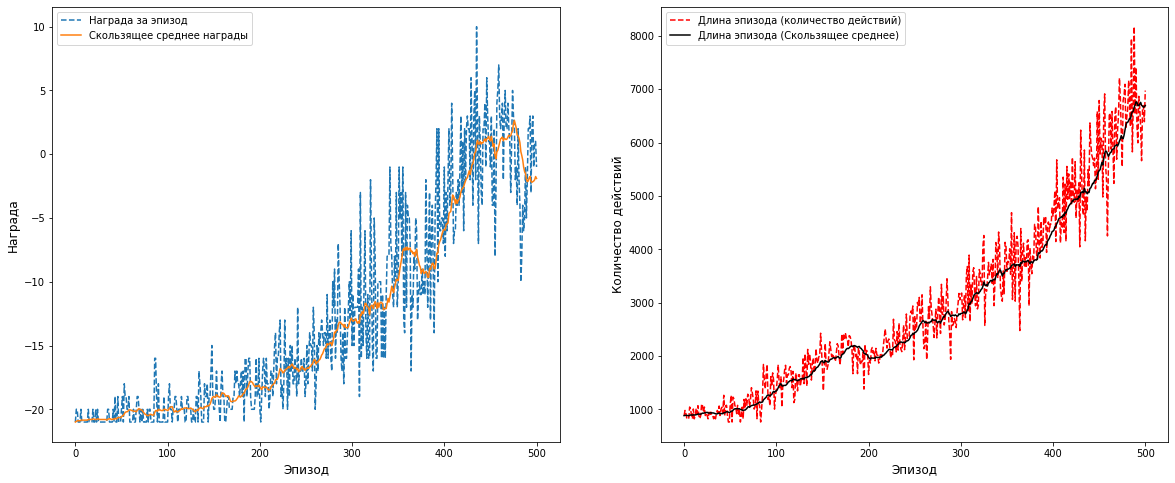

Закончен 501-й эпизод, счёт: (агент) 20 - 21 (противник), продолжительность игры: 6974 кадров.


In [ ]:
# Создаем среду Pong
env = gym.make('ALE/Pong-v5')
env.reset()

while episode_number < 501:

  # Список состояний одного эпизода (для обучения алгоритма)  
  episode_states = [] 

  # Список всех действий за эпизод (для обучения алгоритма)        
  episode_actions = [] 

  # Список всех наград за эпизод (для обучения алгоритма)       
  episode_rewards = []        
  
  # Запускаем среду (это действие возвращает начальное состояние)
  new_frame = env.reset()   

  # Инициализируем предыдущий кадр как текущий кадр       
  old_frame = new_frame            
  
  # Конкатенируем два кадра вместе, чтобы создать состояние
  state = stack_frames(new_frame, old_frame) 
  
  # done — переменная говорит, если игровой эпизод завершен. Инициализируется со значением False
  done = False      

  # Пока игровой эпизод не завершен
  while not done:       

    # Выбираем новое действие по текущему состоянию среды   
    action_index = choose_action(state)  

    # Подаем действие в среду, получаем новый кадр, награду, и узнаем, если игра окончена                                   
    new_frame, reward, done, misc = env.step(action_space[action_index])    
    
    # Добавляем состояние (с которым предсказывали действие) в массив состояний за эпизод
    episode_states.append(state)  

    # Добавляем действие в массив действий за эпизод                   
    episode_actions.append(action_index)  

    # Добавляем полученную награду в массив наград за эпизод           
    episode_rewards.append(reward)  

    # Создаем новое состояния, используя новый кадр (это нужно делать после добавления состояния в массив)                 
    state = stack_frames(new_frame, old_frame)       
    
    # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
    old_frame = new_frame            
  
  # Увеличиваем счетчик (который отвечает за номер эпизода) на 1.
  episode_number += 1

  # Длина эпизода (количество кадров в эпизоде) равна количеству состояний за эпизод                     
  episode_timesteps = len(episode_states) 
  
  # Переводим данные в NumPy-массивы
  episode_states, episode_actions, episode_rewards = np.array(episode_states), np.array(episode_actions), np.array(episode_rewards) 
  
  # Считаем количество положительных наград (равно количеству голов, который забил агент)
  points_won = episode_rewards[episode_rewards > 0].size   
  
  # Считаем количество отрицательных наград (равно количеству голов, который пропустил агент)
  points_lost = episode_rewards[episode_rewards < 0].size  

  # Обучаем модель, используя состояния в эпизоде, соответствующие действия и награды
  train_model(episode_states, episode_actions, episode_rewards) 
  
  # Очки за эпизод = количество забитых голов — количество пропущенных голов
  episode_score = points_won - points_lost   

  # Добавляем количество очков в список (используется в качестве метрики)      
  all_scores.append(episode_score)     

  # Добавляем длину эпизода в список (используется в качестве метрики)            
  all_episode_durations.append(episode_timesteps)  
  
  # Отображаем метрики на графике
  show_scores(all_scores, all_episode_durations)   
  
  # Сохраняем прогресс раз в 10 эпизодов
  if episode_number % 10 == 0:    

    # Сохраняем веса модели
    model.save_weights('/content/REINFORCE.h5')   
    
    # Открываем файл, используя функцию из pickle
    with open('/content/scores.txt', 'wb') as f:  
      
      # Записываем метрики (очки за эпизоды, длины эпизодов, и номер эпизода) в файл
      pickle.dump([all_scores, all_episode_durations, episode_number], f)    

  # Дополнительно выводим статистику за эпизод через print
  print(f"Закончен {episode_number}-й эпизод, счёт: (агент) {points_won} - {points_lost} (противник), продолжительность игры: {episode_timesteps} кадров.")

## Тестирование работы агента

Создадим функцию для выбора действия при тесте. Поскольку алгоритм уже не обучается, ему не нужно разведывать среду. 

В связи с этим есть смысл в создании альтернативной функции для выбора действия. Вместо предсказывания действий рандомным образом, используя вероятности, алгоритм предскажет действия напрямую. Так политика агента станет детерминированной.

In [ ]:
def choose_test_action(state):    
    
  ''' Функция выбора действия при тесте. 

      Аргументы: 
      state - состояние
      
  '''
  # Делаем предсказание
  probs = model.predict(state.reshape(1, 80, 80, 2), verbose=False)  
  
  # Вместо выбора действия рандомно, выбираем действие с максимальной вероятностью
  action_index = np.argmax(probs.flatten())           
  
  # Возвращаем индекс детерминированно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс)
  return action_index   

## Создание видео с игрой агента

In [ ]:
# Создаем среду Pong
env = wrap_env(gym.make('ALE/Pong-v5')) 

# Запускаем среду (это действие возвращает начальное состояние)  
new_frame = env.reset() 

# Инициализируем предыдущий кадр как текущий кадр
old_frame = new_frame      

# Конкатенируем два кадра вместе, чтобы создать состояние
state = stack_frames(new_frame, old_frame) 

# Done — переменная говорит, если игровой эпизод завершен. Инициализируется с значением False
done = False   

# Пока игровой эпизод не завершен
while not done:     

  # Выбираем новое действие по текущему состоянию среды детерминированным образом
  action_index = choose_test_action(state)                                   
  
  # Подаем действие в среду, получаем новый кадр (награда уже не нужна)
  new_frame, reward, done, misc,_ = env.step(action_space[action_index])                     
  
  # Склеиваем новый и старый кадры вместе, чтобы создать новое состояние для подачи в нейросеть
  state = stack_frames(new_frame, old_frame)         
  
  # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
  old_frame = new_frame  
env.close()
show_video()       

**Содержание темы**

1.  [Теория](https://colab.research.google.com/drive/1Qfic-ckzSmXUZ5pyQ7YDzE_gLq9hIA_T?usp=sharing)
2.  Практический ноутбук 1
3. [Практический ноутбук 2](https://colab.research.google.com/drive/16lyctI5oJzVhVC3nQmIIs0tzFRPFPAk_?usp=sharing)